In [1]:
from pystencils.session import *
sp.init_printing()

# Demo: Finite differences - 2D wave equation

In this tutorial we show how to use the finite difference module of *pystencils* to solve a 2D wave equations. The time derivative is discretized by a simple forward Euler method.

$$ \frac{\partial^2 u}{\partial t^2} = \mbox{div} \left( q(x,y) \nabla u \right)$$

We begin by creating three *numpy* arrays for the current, the previous and the next timestep. Actually we will see later that two fields are enough, but let's keep it simple. From these *numpy* arrays we create *pystencils* fields to formulate our update rule.

In [2]:
size = (60, 70) #  domain size
u_arrays = [np.zeros(size), np.zeros(size), np.zeros(size)]

u_fields = [ps.Field.create_from_numpy_array("u%s" % (name,), arr)
            for name, arr in zip(["0", "1", "2"], u_arrays)]

# Nicer display for fields
for i, field in enumerate(u_fields):
    field.latex_name = "u^{(%d)}" % (i,)

*pystencils* contains already simple rules to discretize the a diffusion term. The time discretization is done manually.

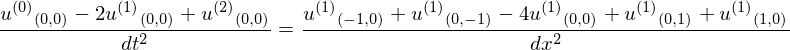

In [3]:
discretize = ps.fd.Discretization2ndOrder()

def central2nd_time_derivative(fields):
    f_next, f_current, f_last = fields
    return (f_next[0, 0] - 2 * f_current[0, 0] + f_last[0, 0]) / discretize.dt**2

rhs = ps.fd.diffusion(u_fields[1], 1)

wave_eq = sp.Eq(central2nd_time_derivative(u_fields), discretize(rhs))

wave_eq = sp.simplify(wave_eq)
wave_eq

The explicit Euler scheme is now obtained by solving above equation with respect to $u_C^{next}$.

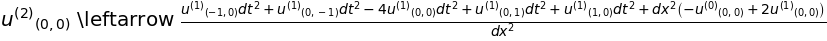

In [4]:
u_next_C = u_fields[-1][0, 0]
update_rule = ps.Assignment(u_next_C, sp.solve(wave_eq, u_next_C)[0])
update_rule

Before creating the kernel, we substitute numeric values for $dx$ and $dt$. 
Then a kernel is created just like in the last tutorial.

In [5]:
update_rule = update_rule.subs({discretize.dx: 0.1, discretize.dt: 0.05})
ast = ps.create_kernel(update_rule)
kernel = ast.compile()

ps.show_code(ast)

FUNC_PREFIX void kernel(double * const _data_u0, double * const _data_u1, double * _data_u2)
{
   for (int ctr_0 = 1; ctr_0 < 59; ctr_0 += 1)
   {
      double * _data_u2_00 = _data_u2 + 70*ctr_0;
      double * const _data_u1_00 = _data_u1 + 70*ctr_0;
      double * const _data_u0_00 = _data_u0 + 70*ctr_0;
      double * const _data_u1_01 = _data_u1 + 70*ctr_0 + 70;
      double * const _data_u1_0m1 = _data_u1 + 70*ctr_0 - 70;
      for (int ctr_1 = 1; ctr_1 < 69; ctr_1 += 1)
      {
         _data_u2_00[ctr_1] = 0.25*_data_u1_00[ctr_1 + 1] + 0.25*_data_u1_00[ctr_1 - 1] + 0.25*_data_u1_01[ctr_1] + 0.25*_data_u1_0m1[ctr_1] - 1.0*_data_u0_00[ctr_1] + 1.0*_data_u1_00[ctr_1];
      }
   }
}

In [6]:
ast.get_parameters()

[_data_u0, _data_u1, _data_u2]

In [7]:
ast.fields_accessed

{u0, u1, u2}

To run simulation a suitable initial condition and boundary treatment is required. We chose an initial condition which is zero at the borders of the domain. The outermost layer is not changed by the update kernel, so we have an implicit homogenous Dirichlet boundary condition.

In [8]:
X,Y = np.meshgrid( np.linspace(0, 1, size[1]), np.linspace(0,1, size[0]))
Z = np.sin(2*X*np.pi) * np.sin(2*Y*np.pi)

# Initialize the previous and current values with the initial function
np.copyto(u_arrays[0], Z)
np.copyto(u_arrays[1], Z)
# The values for the next timesteps do not matter, since they are overwritten
u_arrays[2][:, :] = 0

One timestep now consists of applying the kernel once, then shifting the arrays.

In [9]:
def run(timesteps=1):
    for t in range(timesteps):
        kernel(u0=u_arrays[0], u1=u_arrays[1], u2=u_arrays[2])
        u_arrays[0], u_arrays[1], u_arrays[2] = u_arrays[1], u_arrays[2], u_arrays[0]
    return u_arrays[2]

Lets create an animation of the solution:

In [10]:
ps_notebook.set_display_mode('video')
ani = plt.surface_plot_animation(run)
ps_notebook.display_animation(ani)

In [11]:
assert np.isfinite(np.max(u_arrays[2]))

__LLVM backend__

The next cell demonstrates how to run the same simulation with the LLVM backend. The only difference is that in the `create_kernel` function the `target` is set to llvm.

In [12]:
try:
    import llvmlite
except ImportError:
    llvmlite=None
    print('No llvmlite installed')

if llvmlite:
    kernel = ps.create_kernel(update_rule, target='llvm').compile()
    
    X,Y = np.meshgrid( np.linspace(0, 1, size[1]), np.linspace(0,1, size[0]))
    Z = np.sin(2*X*np.pi) * np.sin(2*Y*np.pi)

    # Initialize the previous and current values with the initial function
    np.copyto(u_arrays[0], Z)
    np.copyto(u_arrays[1], Z)
    # The values for the next timesteps do not matter, since they are overwritten
    u_arrays[2][:, :] = 0
    
    def run_LLVM(timesteps=1):
        for t in range(timesteps):
            kernel(u0=u_arrays[0], u1=u_arrays[1], u2=u_arrays[2])
            u_arrays[0], u_arrays[1], u_arrays[2] = u_arrays[1], u_arrays[2], u_arrays[0]
        return u_arrays[2]
    
    ani = plt.surface_plot_animation(run_LLVM)
    assert np.isfinite(np.max(u_arrays[2]))
ps_notebook.display_animation(ani)

__Runing on GPU__

We can also run the same kernel on the GPU, by using the ``pycuda`` package.

In [13]:
try:
    import pycuda
except ImportError:
    pycuda=None
    print('No pycuda installed')


res = None
if pycuda:
    gpu_ast = ps.create_kernel(update_rule, target='gpu')
    gpu_kernel = gpu_ast.compile()
    res = ps.show_code(gpu_ast)
res

FUNC_PREFIX void kernel(double * const _data_u0, double * const _data_u1, double * _data_u2)
{
   if (blockDim.x*blockIdx.x + threadIdx.x + 1 < 59 && blockDim.y*blockIdx.y + threadIdx.y + 1 < 69)
   {
      const int64_t ctr_0 = blockDim.x*blockIdx.x + threadIdx.x + 1;
      const int64_t ctr_1 = blockDim.y*blockIdx.y + threadIdx.y + 1;
      double * _data_u2_10 = _data_u2 + ctr_1;
      double * const _data_u1_10 = _data_u1 + ctr_1;
      double * const _data_u0_10 = _data_u0 + ctr_1;
      double * const _data_u1_11 = _data_u1 + ctr_1 + 1;
      double * const _data_u1_1m1 = _data_u1 + ctr_1 - 1;
      _data_u2_10[70*ctr_0] = 0.25*_data_u1_10[70*ctr_0 + 70] + 0.25*_data_u1_10[70*ctr_0 - 70] + 0.25*_data_u1_11[70*ctr_0] + 0.25*_data_u1_1m1[70*ctr_0] - 1.0*_data_u0_10[70*ctr_0] + 1.0*_data_u1_10[70*ctr_0];
   } 
}

The run function has to be changed now slightly, since the data has to be transfered to the GPU first, then the kernel can be executed, and in the end the data has to be transfered back

In [14]:
if pycuda:
    import pycuda.gpuarray as gpuarray

    def run_on_gpu(timesteps=1):
        # Transfer arrays to GPU
        gpuArrs = [gpuarray.to_gpu(a) for a in u_arrays]

        for t in range(timesteps):
            gpu_kernel(u0=gpuArrs[0], u1=gpuArrs[1], u2=gpuArrs[2])
            gpuArrs[0], gpuArrs[1], gpuArrs[2] = gpuArrs[1], gpuArrs[2], gpuArrs[0]

        # Transfer arrays to CPU
        for gpuArr, cpuArr in zip(gpuArrs, u_arrays):
            gpuArr.get(cpuArr)
assert np.isfinite(np.max(u_arrays[2]))            

In [15]:
if pycuda:
    run_on_gpu(400)